In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


# **Introduction**

In this project, we aim to build an SMS classifier to differentiate between spam and ham (non-spam) messages. With the ever-increasing reliance on text-based communication, such a system can help filter unwanted spam messages, enhancing user experience and productivity.

---

# **Objective**

The primary objective of this project is to:
- Analyze and preprocess SMS data.
- Build a robust machine learning model to classify messages as spam or ham.
- Evaluate the model's performance using relevant metrics.

In [2]:
#Importing all the libraries to be used
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [4]:
data = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding='Windows-1252')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
# Dropping the redundent looking collumns (for this project)
to_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
data = data.drop(data[to_drop], axis=1)
# Renaming the columns because I feel fancy today 
data.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
data.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
data.shape

(5572, 2)

In [7]:
# Count the occurrences of each class
target_counts = data['Target'].value_counts()

# Calculate percentages
target_percentages = (target_counts / len(data)) * 100

# Display the results
print("Class Distribution (Percentage):")
print(target_percentages)

Class Distribution (Percentage):
Target
ham     86.593683
spam    13.406317
Name: count, dtype: float64


# **Dataset Overview**

The dataset used for this project is the "SMS Spam Collection Dataset," which contains labeled text messages categorized into two classes:
- **Ham**: Legitimate (non-spam) messages.
- **Spam**: Unwanted promotional or malicious messages.

Key details:
- **Total messages**: `5572`
- **Ham messages**: `4825` (~86.59%)
- **Spam messages**: `747` (~13.41%)


# **Exploratory Data Analysis**

EDA helps us understand the dataset better and uncover patterns that may aid in building a better model. In this section, we will:
1. Visualize the class distribution of messages.
2. Analyze the length of messages across spam and ham categories.
3. Explore the most common words in spam and ham messages using word clouds.

Text(0, 0.5, 'Number of Data points')

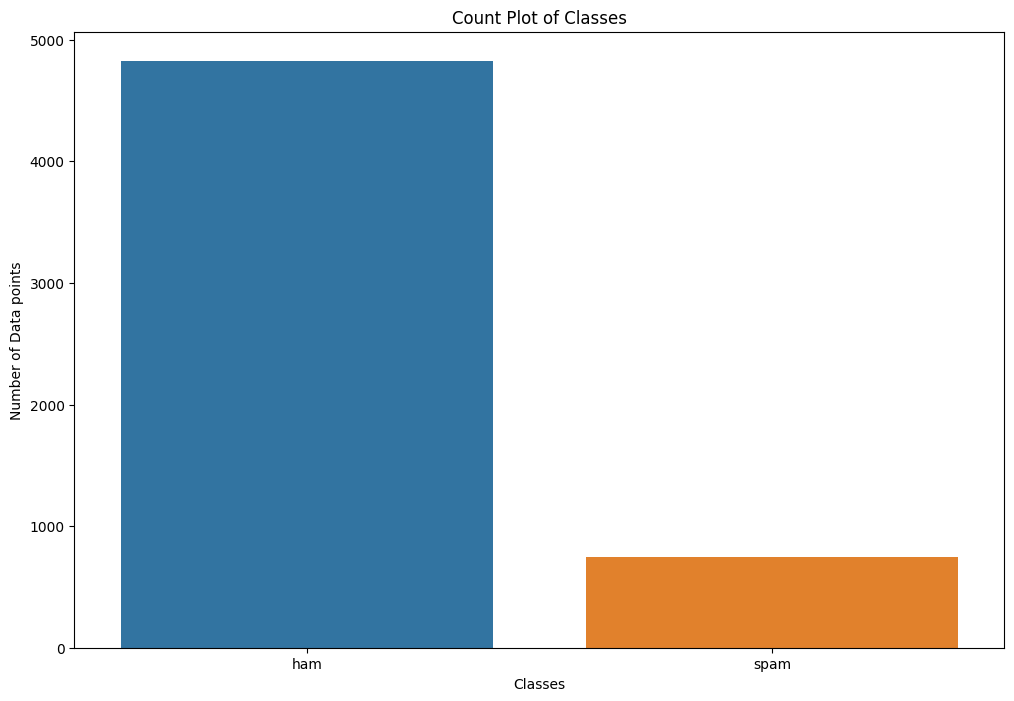

In [8]:
#first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(12,8))
fg = sns.countplot(x= data["Target"])
fg.set_title("Count Plot of Classes")
fg.set_xlabel("Classes")
fg.set_ylabel("Number of Data points")

In [9]:
#Adding a column of numbers of charachters,words and sentences in each msg
data["No_of_Characters"] = data["Text"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)

data.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_Words,5572.0,18.501256,13.637056,1.0,9.0,15.0,27.0,219.0
No_of_sentence,5572.0,1.991565,1.501427,1.0,1.0,1.5,2.0,38.0


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1200x800 with 0 Axes>

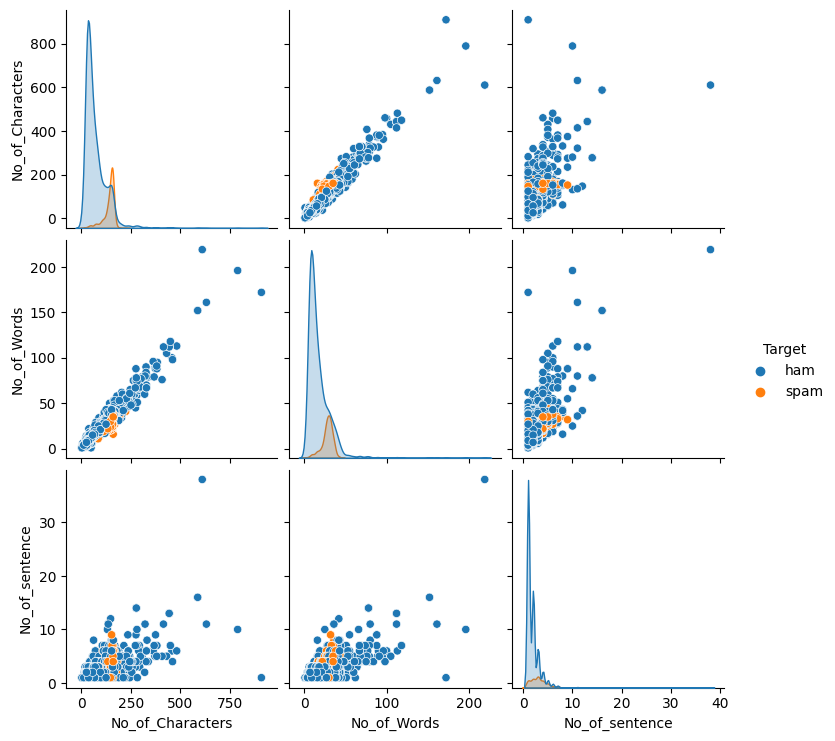

In [10]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target")
plt.show(fg)

In [11]:
data.head()

,Target,Text,No_of_Characters,No_of_Words,No_of_sentence
0,ham,"Go until jurong point, crazy.. Available only ...",111,23,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


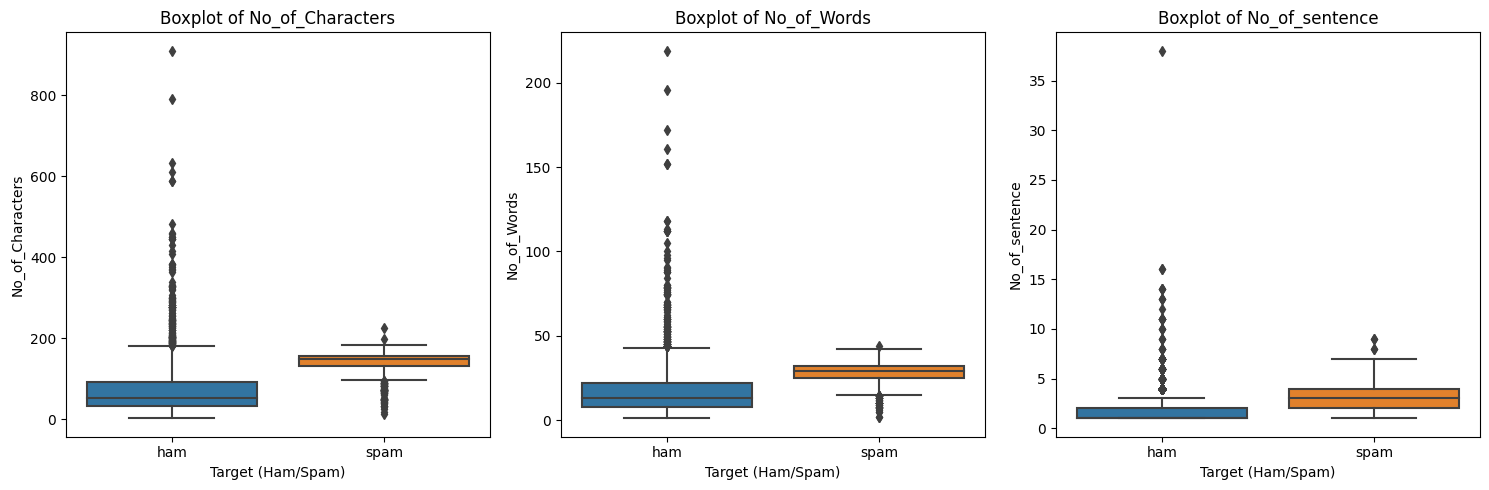

In [12]:
# Features to analyze
features = ['No_of_Characters', 'No_of_Words', 'No_of_sentence']

# Plotting boxplots
plt.figure(figsize=(15, 5))
for i, feature in enumerate(features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Target', y=feature, data=data)
    plt.title(f'Boxplot of {feature}')
    plt.xlabel('Target (Ham/Spam)')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

In [13]:
# Function to detect outliers using IQR
def detect_outliers(feature):
    Q1 = data[feature].quantile(0.25)  # 25th percentile
    Q3 = data[feature].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]

# Detect outliers for each feature
for feature in features:
    outliers = detect_outliers(feature)
    print(f"Outliers in {feature}:\n", outliers)

Outliers in No_of_Characters:
      Target                                               Text  \
53      ham  Wow. I never realized that you were so embaras...   
154     ham  You are everywhere dirt, on the floor, the win...   
380     ham  I guess that's why you re worried. You must kn...   
472     ham  Nothing. I meant that once the money enters yo...   
550     ham  Imagine you finally get to sink into that bath...   
...     ...                                                ...   
5209    ham  I know you are thinkin malaria. But relax, chi...   
5264    ham  Storming msg: Wen u lift d phne, u say \HELLO\...   
5451    ham  Just sing HU. I think its also important to fi...   
5535    ham  I know you are thinkin malaria. But relax, chi...   
5557    ham  No. I meant the calculation is the same. That ...   

      No_of_Characters  No_of_Words  No_of_sentence  
53                 291           69               6  
154                384           95               5  
380           

In [14]:
data.shape

(5572, 5)

In [15]:
for feature in features:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]

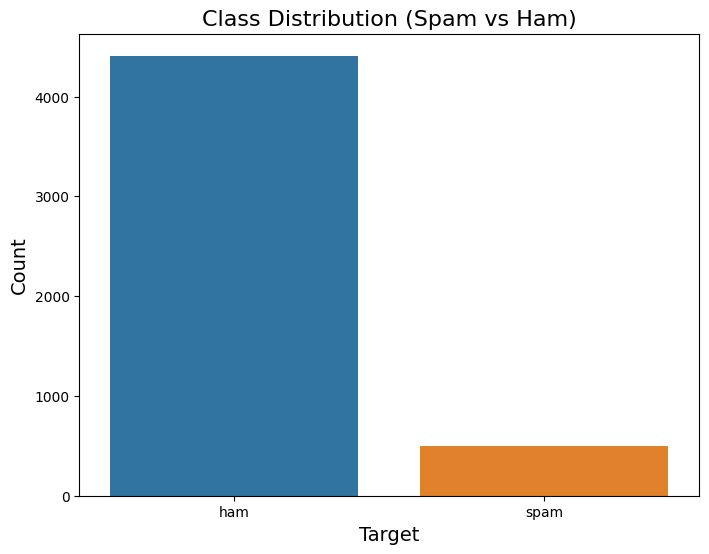

In [16]:
# Checking class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Target')
plt.title('Class Distribution (Spam vs Ham)', fontsize=16)
plt.xlabel('Target', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()


In [17]:
df.head()

,Target,Text,No_of_Characters,No_of_Words,No_of_sentence
0,ham,"Go until jurong point, crazy.. Available only ...",111,23,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


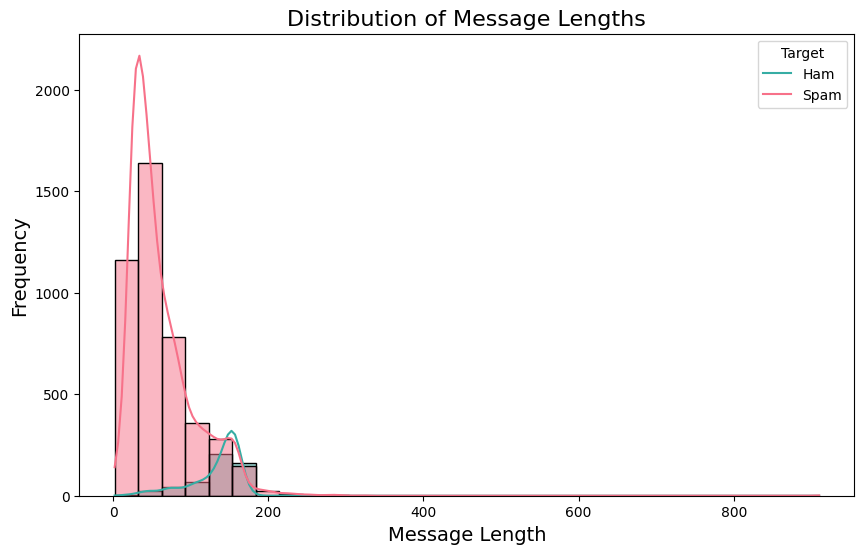

In [18]:
# Distribution of message lengths
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='No_of_Characters', hue='Target', kde=True, bins=30, palette='husl')
plt.title('Distribution of Message Lengths', fontsize=16)
plt.xlabel('Message Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Target', labels=['Ham', 'Spam'])
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1200x800 with 0 Axes>

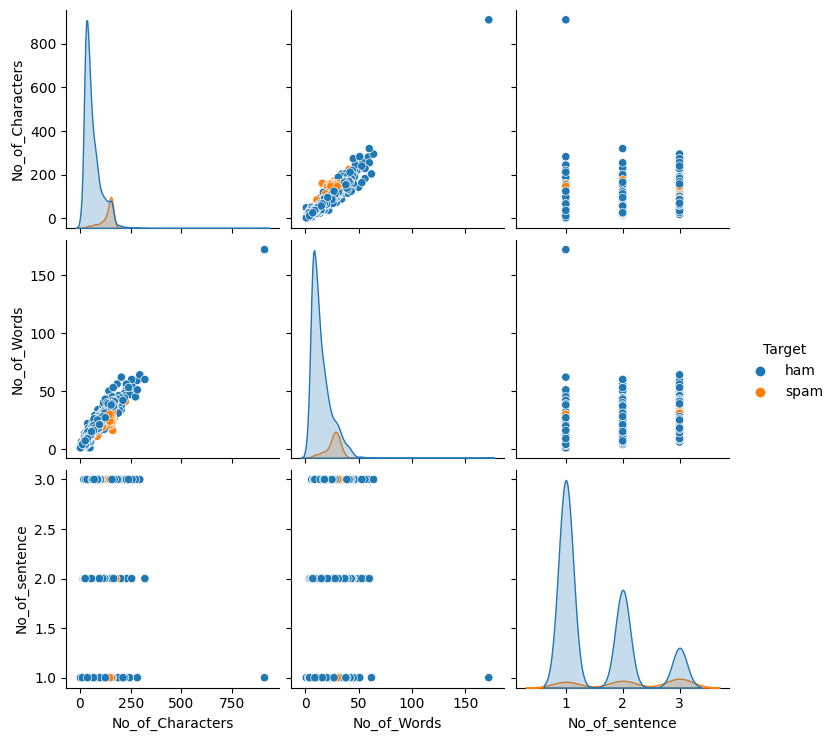

In [19]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=df, hue="Target")
plt.show(fg)

In [20]:
df.shape

(4910, 5)

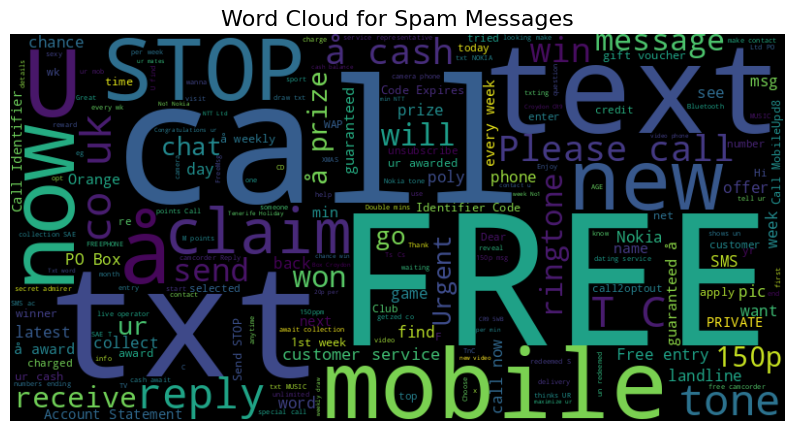

In [21]:
from wordcloud import WordCloud

# Generating a word cloud for Spam messages
spam_text = ' '.join(df[df['Target'] == 'spam']['Text'])
spam_wc = WordCloud(width=800, height=400, background_color='black').generate(spam_text)

plt.figure(figsize=(10, 6))
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Spam Messages', fontsize=16)
plt.show()

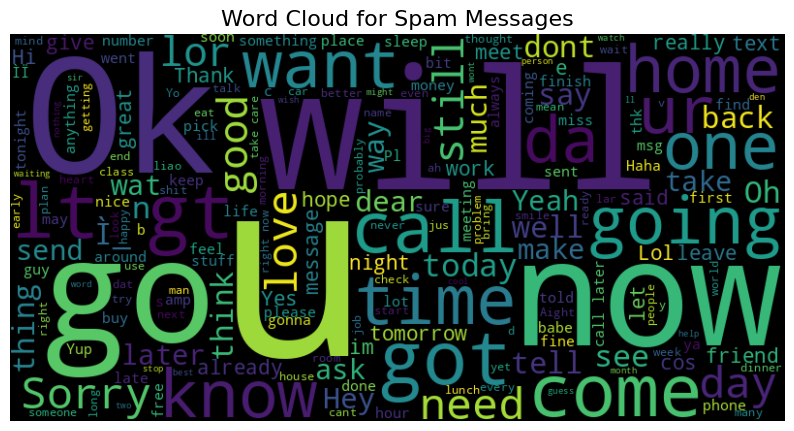

In [22]:
from wordcloud import WordCloud

# Generating a word cloud for Non Spam messages
spam_text = ' '.join(df[df['Target'] == 'ham']['Text'])
spam_wc = WordCloud(width=800, height=400, background_color='black').generate(spam_text)

plt.figure(figsize=(10, 6))
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Spam Messages', fontsize=16)
plt.show()


# **Data Preprocessing**

Before training our machine learning model, we preprocess the text data:
- Convert text to lowercase.
- Remove punctuation, special characters, and stopwords.
- Apply stemming or lemmatization to normalize words.

These steps ensure that the data is clean and ready for feature extraction.

In [23]:
# Defining a function to clean up the text
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

df["Clean_Text"] = df["Text"].apply(Clean)
#Lets have a look at a sample of texts after cleaning
print("\033[1m\u001b[45;1m The First 5 Texts after cleaning:\033[0m",*df["Clean_Text"][:5], sep = "\n")

 The First 5 Texts after cleaning:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


<ipython-input-23-69c7c2a34432>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Clean_Text"] = df["Text"].apply(Clean)


In [24]:
df["Tokenize_Text"]=df.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

print("\033[1m\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m",*df["Tokenize_Text"][:5], sep = "\n")

 The First 5 Texts after Tokenizing:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


<ipython-input-24-cf458441f6e3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Tokenize_Text"]=df.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)


In [25]:
# Removing the stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

df["Nostopword_Text"] = df["Tokenize_Text"].apply(remove_stopwords)

print("\033[1m\u001b[45;1m The First 5 Texts after removing the stopwords:\033[0m",*df["Nostopword_Text"][:5], sep = "\n")

 The First 5 Texts after removing the stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


<ipython-input-25-22fb1b4c74ff>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Nostopword_Text"] = df["Tokenize_Text"].apply(remove_stopwords)


In [26]:
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    #word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

df["Lemmatized_Text"] = df["Nostopword_Text"].apply(lemmatize_word)
print("\033[1m\u001b[45;1m The First 5 Texts after lemitization:\033[0m",*df["Lemmatized_Text"][:5], sep = "\n")

 The First 5 Texts after lemitization:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


<ipython-input-26-bebb1651f125>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Lemmatized_Text"] = df["Nostopword_Text"].apply(lemmatize_word)


In [27]:
#Creating a corpus of text feature to encode further into vectorized form
corpus= []
for i in df["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
    
corpus[:5]
print("\033[1m\u001b[45;1m The First 5 lines in corpus :\033[0m",*corpus[:5], sep = "\n")

 The First 5 lines in corpus :
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


# **Modeling**

For the classification task, we employ the following steps:
1. **Feature Extraction**:
   - Transform text data using techniques like TF-IDF vectorization to convert text into numerical representations.
2. **Model Selection**:
   - Train multiple models such as Logistic Regression, Naive Bayes, and SVM to identify the best-performing algorithm.
3. **Evaluation**:
   - Use metrics such as precision, recall, F1-score, and accuracy to evaluate the performance of the models.

---

In [28]:
#Changing text data in to numbers. 
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
#Let's have a look at our feature 
X.dtype

dtype('float64')

In [29]:
#Label encode the Target and use it as y
label_encoder = LabelEncoder()
df["Target"] = label_encoder.fit_transform(df["Target"])

<ipython-input-29-dd7530ef82ca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Target"] = label_encoder.fit_transform(df["Target"])


In [30]:
#Setting values for labels and feature as y and X(we already did X in vectorizing...)
y = df["Target"] 
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [32]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)

print_score(lr_clf, X_train, y_train, X_test, y_test, train=True)
print_score(lr_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 96.69%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.965912    0.980843  0.966904     0.973378      0.967360
recall        0.998590    0.671916  0.966904     0.835253      0.966904
f1-score      0.981979    0.797508  0.966904     0.889744      0.964086
support    3547.000000  381.000000  0.966904  3928.000000   3928.000000
_______________________________________________
Confusion Matrix: 
 [[3542    5]
 [ 125  256]]

Test Result:
Accuracy Score: 94.60%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.944018    0.971831  0.946029    0.957924      0.947416
recall       0.997680    0.575000  0.946029    0.786340      0.946029
f1-score     0.970107    0.722513  0.946029    0.846310      0.939851
support    862.000000  120.000000  0.946029  982.

In [33]:
test_score = accuracy_score(y_test, lr_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, lr_clf.predict(X_train)) * 100

results_df = pd.DataFrame(data=[["Logistic Regression", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,96.690428,94.602851


In [34]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

print_score(knn_clf, X_train, y_train, X_test, y_test, train=True)
print_score(knn_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 93.99%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.937616    1.000000  0.939919     0.968808      0.943667
recall        1.000000    0.380577  0.939919     0.690289      0.939919
f1-score      0.967804    0.551331  0.939919     0.759567      0.927407
support    3547.000000  381.000000  0.939919  3928.000000   3928.000000
_______________________________________________
Confusion Matrix: 
 [[3547    0]
 [ 236  145]]

Test Result:
Accuracy Score: 91.34%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.910243    1.000000  0.913442    0.955121      0.921211
recall       1.000000    0.291667  0.913442    0.645833      0.913442
f1-score     0.953013    0.451613  0.913442    0.702313      0.891742
support    862.000000  120.000000  0.913442  982.

In [35]:
test_score = accuracy_score(y_test, knn_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, knn_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["K-nearest neighbors", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,96.690428,94.602851
1,K-nearest neighbors,93.991853,91.344196


In [36]:
from sklearn.svm import SVC


svm_clf = SVC(kernel='rbf', gamma=0.1, C=1.0)
svm_clf.fit(X_train, y_train)

print_score(svm_clf, X_train, y_train, X_test, y_test, train=True)
print_score(svm_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 96.66%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.964888    0.992126   0.96665     0.978507      0.967530
recall        0.999436    0.661417   0.96665     0.830427      0.966650
f1-score      0.981858    0.793701   0.96665     0.887780      0.963608
support    3547.000000  381.000000   0.96665  3928.000000   3928.000000
_______________________________________________
Confusion Matrix: 
 [[3545    2]
 [ 129  252]]

Test Result:
Accuracy Score: 94.60%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.943045    0.985507  0.946029    0.964276      0.948234
recall       0.998840    0.566667  0.946029    0.782753      0.946029
f1-score     0.970141    0.719577  0.946029    0.844859      0.939522
support    862.000000  120.000000  0.946029  982.

In [37]:
test_score = accuracy_score(y_test, svm_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, svm_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["Support Vector Machine", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,96.690428,94.602851
1,K-nearest neighbors,93.991853,91.344196
2,Support Vector Machine,96.664969,94.602851


In [38]:
from sklearn.tree import DecisionTreeClassifier


tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                0      1  accuracy  macro avg  weighted avg
precision     1.0    1.0       1.0        1.0           1.0
recall        1.0    1.0       1.0        1.0           1.0
f1-score      1.0    1.0       1.0        1.0           1.0
support    3547.0  381.0       1.0     3928.0        3928.0
_______________________________________________
Confusion Matrix: 
 [[3547    0]
 [   0  381]]

Test Result:
Accuracy Score: 96.23%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.974684    0.867257  0.962322    0.920970      0.961556
recall       0.982599    0.816667  0.962322    0.899633      0.962322
f1-score     0.978625    0.841202  0.962322    0.909913      0.961832
support    862.000000  120.000000  0.962322  982.000000    982.000000
______________________________________

In [39]:
test_score = accuracy_score(y_test, tree_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, tree_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["Decision Tree Classifier", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = pd.concat([results_df,results_df_2], ignore_index=True)
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,96.690428,94.602851
1,K-nearest neighbors,93.991853,91.344196
2,Support Vector Machine,96.664969,94.602851
3,Decision Tree Classifier,100.000000,96.232179


In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_clf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_clf.fit(X_train, y_train)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                0      1  accuracy  macro avg  weighted avg
precision     1.0    1.0       1.0        1.0           1.0
recall        1.0    1.0       1.0        1.0           1.0
f1-score      1.0    1.0       1.0        1.0           1.0
support    3547.0  381.0       1.0     3928.0        3928.0
_______________________________________________
Confusion Matrix: 
 [[3547    0]
 [   0  381]]

Test Result:
Accuracy Score: 97.56%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.972912    1.000000   0.97556    0.986456      0.976222
recall       1.000000    0.800000   0.97556    0.900000      0.975560
f1-score     0.986270    0.888889   0.97556    0.937579      0.974370
support    862.000000  120.000000   0.97556  982.000000    982.000000
______________________________________

In [41]:
test_score = accuracy_score(y_test, rf_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, rf_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["Random Forest Classifier", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = pd.concat([results_df,results_df_2], ignore_index=True)
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,96.690428,94.602851
1,K-nearest neighbors,93.991853,91.344196
2,Support Vector Machine,96.664969,94.602851
3,Decision Tree Classifier,100.000000,96.232179
4,Random Forest Classifier,100.000000,97.556008


In [42]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(use_label_encoder=False)
xgb_clf.fit(X_train, y_train)

print_score(xgb_clf, X_train, y_train, X_test, y_test, train=True)
print_score(xgb_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 99.29%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.992443    0.997183  0.992872     0.994813      0.992903
recall        0.999718    0.929134  0.992872     0.964426      0.992872
f1-score      0.996067    0.961957  0.992872     0.979012      0.992759
support    3547.000000  381.000000  0.992872  3928.000000   3928.000000
_______________________________________________
Confusion Matrix: 
 [[3546    1]
 [  27  354]]

Test Result:
Accuracy Score: 97.45%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.979381    0.93578  0.974542    0.957581      0.974053
recall       0.991879    0.85000  0.974542    0.920940      0.974542
f1-score     0.985591    0.89083  0.974542    0.938210      0.974011
support    862.000000  120.00000  0.974542  982.00000

In [43]:
test_score = accuracy_score(y_test, xgb_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, xgb_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["XGBoost Classifier", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = pd.concat([results_df,results_df_2], ignore_index=True)
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,96.690428,94.602851
1,K-nearest neighbors,93.991853,91.344196
2,Support Vector Machine,96.664969,94.602851
3,Decision Tree Classifier,100.000000,96.232179
4,Random Forest Classifier,100.000000,97.556008
5,XGBoost Classifier,99.287169,97.454175


# Model Performance Summary

## Best-Performing Model
- **Random Forest Classifier**: Accuracy of **97.55%**
- **Precision**: 1
- **Recall**: 0.8

## Potential Areas of Improvement:
- Adding more advanced models or neural networks.
- Expanding the dataset for better generalization.

## Preferred Model
Even though **XGBoost Classifier** has a slightly lower accuracy of **97.45%**, I prefer this model due to its higher:
- **Precision**: 0.92
- **Recall**: 0.85


# **Precision and Recall**

### **Precision**
Precision measures the accuracy of the positive predictions made by a classifier. It is the ratio of correctly predicted positive observations to the total predicted positive observations.

Precision = True Positives (TP) / [True Positives (TP) + False Positives (FP)]




- **High Precision**: Indicates that the model is good at predicting spam (positive class) without mistakenly labeling ham (negative class) as spam.

---

### **Recall (Sensitivity or True Positive Rate)**
Recall measures the ability of a classifier to identify all relevant positive observations. It is the ratio of correctly predicted positive observations to all actual positive observations.

Recall = True Positives (TP) / [True Positives (TP) + False Negatives (FN)]


- **High Recall**: Indicates that the model is good at catching all spam messages, even if it sometimes misclassifies ham as spam.

---

### **Impact in SMS Classification**

In the context of SMS classification (spam vs ham), the consequences of misclassification are crucial:

- **False Positive (FP)**: A ham message (important, legitimate text) is classified as spam.
- **False Negative (FN)**: A spam message is classified as ham and bypasses the filter.

---

### **When to Prefer Precision or Recall?**

- **Precision**:  
  Precision is more critical if the goal is to ensure that ham messages are rarely misclassified as spam. For example:
  - In cases like banking notifications or critical alerts, we want to avoid blocking legitimate messages.

- **Recall**:  
  Recall is more critical if the goal is to catch as many spam messages as possible, even if a few ham messages are misclassified as spam. For example:
  - In scenarios where spam messages are potentially harmful (e.g., phishing links), it’s better to err on the side of caution.

---

### **Conclusion**
In most SMS spam detection systems, **Recall** is generally prioritized because:
- Missing a spam message (False Negative) can lead to user harm (e.g., phishing, scams).
- Misclassifying a legitimate message as spam (False Positive) is usually less harmful, as users can still check their spam folders.
